# Amazon Alexa Sentiment Analysis

Analyzing Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative

## Importing Libraries

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from wordcloud import WordCloud
import pickle
import re

## Exploratory Data Analysis

In [3]:
# Load the data

data = pd.read_csv(r'/Users/derek/Desktop/PyCharm./Unit_4_X_DL/xccelerate_p8/amazon_alexa.tsv', delimiter = '\t', quoting = 3)

print (f'Dataset shape: {data.shape}')

Dataset shape: (3150, 5)


In [4]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
data.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1
3149,4,29-Jul-18,Black Dot,Good,1


In [14]:
# Null value

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [15]:
# Dropping null value

data.dropna(inplace=True)

In [18]:
print(f'Dataset shape after dropping null value: {data.shape}')

Dataset shape after dropping null value: (3149, 5)


In [19]:
# Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [20]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [21]:
# Datatype of the features

data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

rating, feedback, length = int64
date, variation, verified_reviews = object

## Analyzing 'rating' column

In [28]:
data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

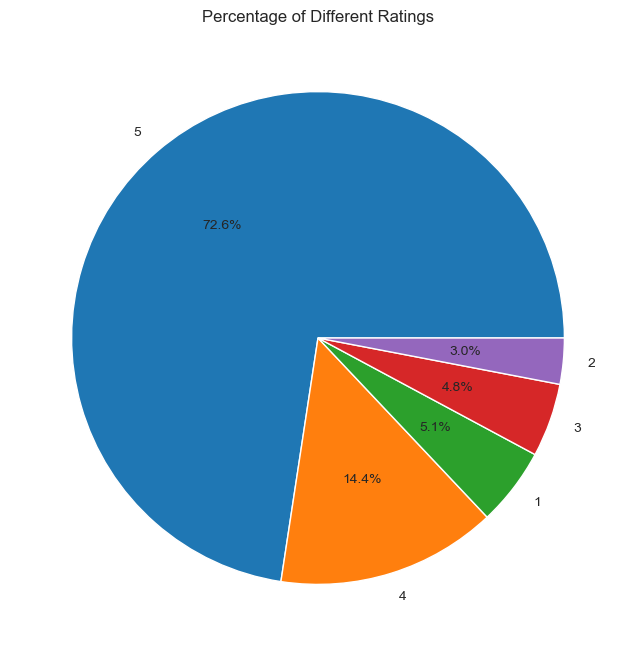

In [26]:
rating_counts = data['rating'].value_counts()

plt.figure(figsize=(10,8))
plt.pie(rating_counts, labels=rating_counts.index,autopct='%1.1f%%')
plt.title ('Percentage of Different Ratings')
plt.show()

## Analyzing 'feedback' column

In [29]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

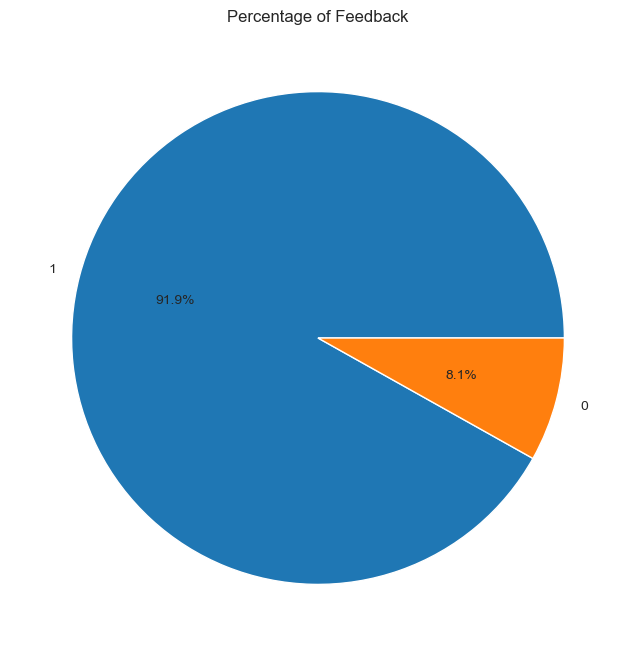

In [31]:
feedback_counts = data['feedback'].value_counts()

plt.figure(figsize=(10,8))
plt.pie(feedback_counts, labels=feedback_counts.index,autopct='%1.1f%%')
plt.title ('Percentage of Feedback')
plt.show()

In [41]:
# Extracting the 'verified_reviews' value for one record with feedback = 0

review_0 = data[data['feedback']==0].iloc[4]['verified_reviews']
print(review_0)

Sad joke. Worthless.


In [45]:
# Extracting the 'verified_reviews' value for one record with feedback = 1

review_1 = data[data['feedback']==1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


In [46]:
# Feedback 0 

data[data['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [49]:
# Feedback 1

data[data['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

Feedback = 0 --> Negative reviews --> 91.9% --> Total 2893 --> 161 (1 rating), 95 (2 rating)
Feedback = 1 --> Positive reviews --> 8.1% --> Total 256 --> 2286 (5 rating), 455 (4 rating), 152 (3 rating)

## Analyzing 'variation' column

In [50]:
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

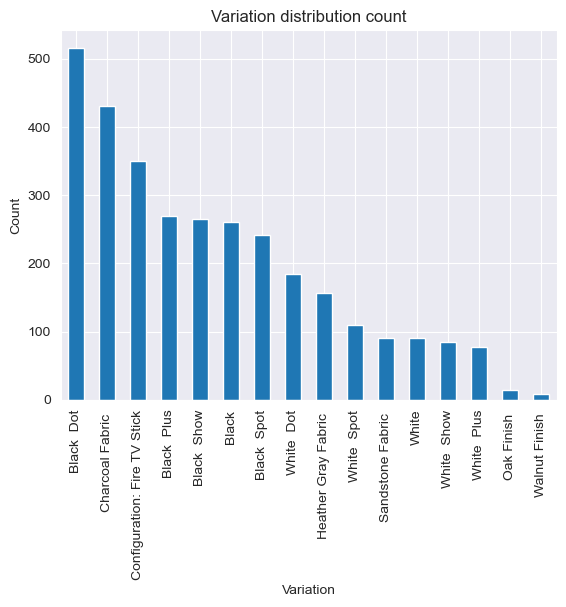

In [62]:
# Bar graph

data['variation'].value_counts().plot.bar()
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [52]:
round(data['variation'].value_counts()/data.shape[0]*100,2)

variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64

In [53]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

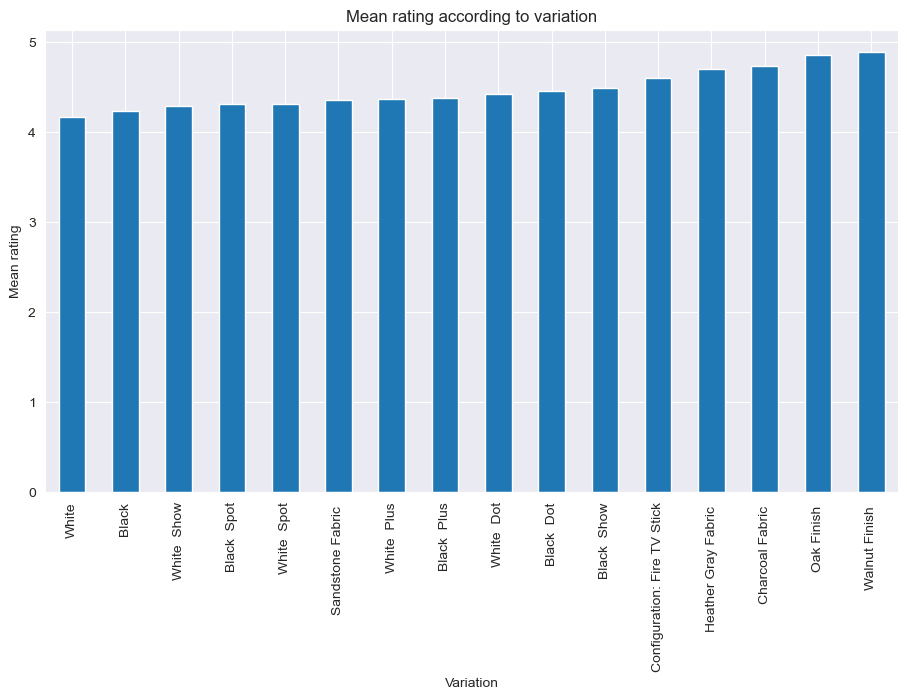

In [61]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(figsize=(11,6))
plt.title('Mean rating according to variation')
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

## Analyzing 'verified_reviews' column

In [55]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

/Users/derek/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


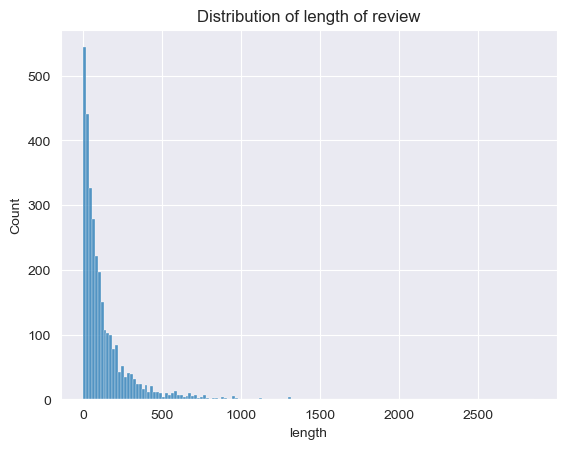

In [96]:
sns.histplot(data['length']).set(title='Distribution of length of review')
plt.show()

/Users/derek/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


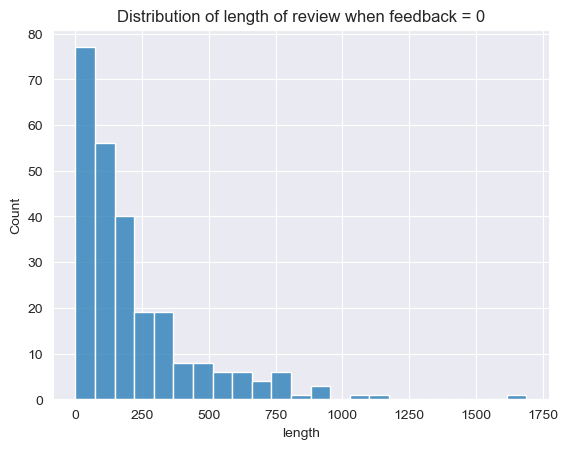

In [59]:
sns.histplot(data[data['feedback']==0]['length']).set(title='Distribution of length of review when feedback = 0')
plt.show()

/Users/derek/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


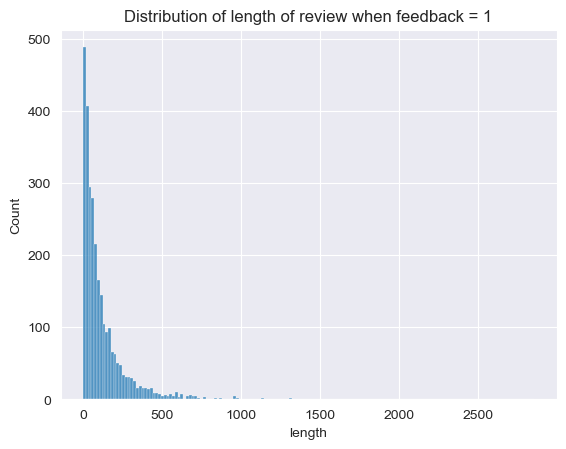

In [60]:
sns.histplot(data[data['feedback']==1]['length']).set(title='Distribution of length of review when feedback = 1')
plt.show()

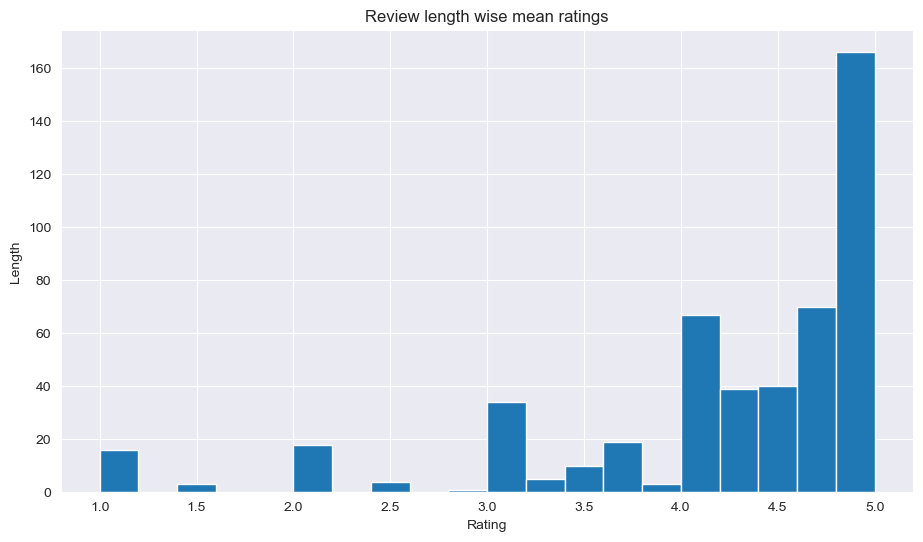

In [63]:
data.groupby('length')['rating'].mean().plot.hist(figsize=(11,6),bins = 20)
plt.title('Review length wise mean ratings')
plt.xlabel('Rating')
plt.ylabel('Length')
plt.show()

In [64]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)

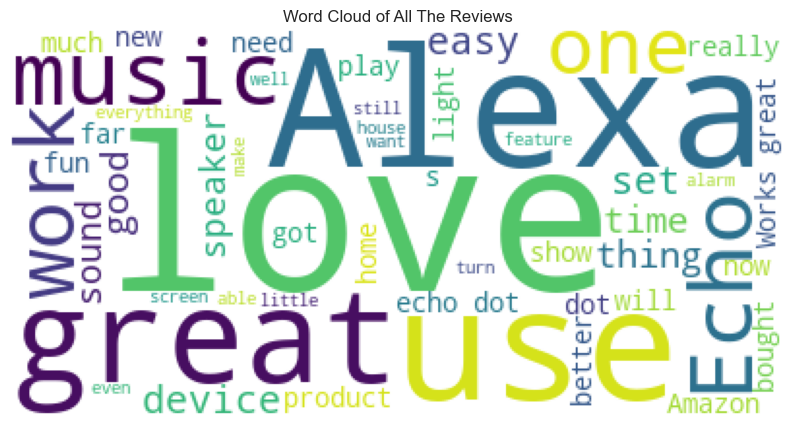

In [68]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud (background_color = 'white', max_words = 50)

# Generate and plot wordcloud
plt.figure(figsize=(10,8))
plt.imshow(wc.generate(reviews))
plt.axis('off')
plt.title('Word Cloud of All The Reviews')
plt.show()

In [69]:
# Combine all reviews for each feedback category splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

# Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

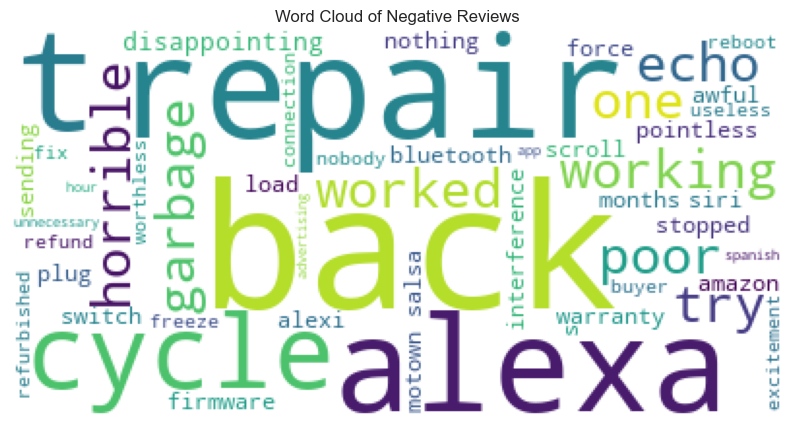

In [71]:
wc = WordCloud(background_color = 'white', max_words =50)

# Generate and plot word cloud
plt.figure(figsize=(10,8))
plt.imshow(wc.generate(unique_negative))
plt.title('Word Cloud of Negative Reviews')
plt.axis('off')
plt.show()

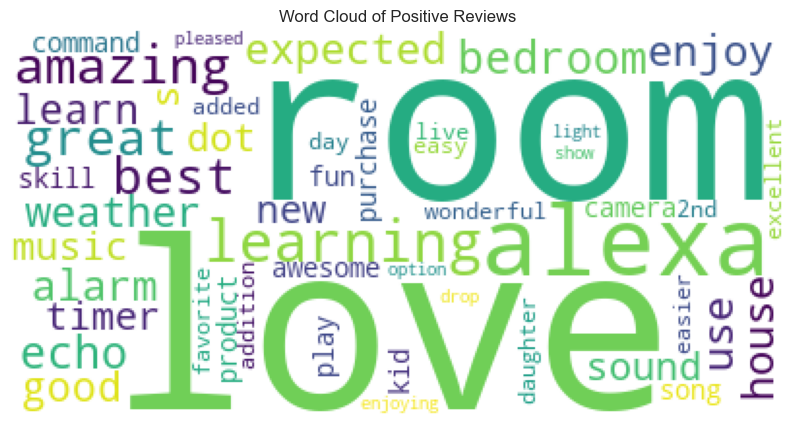

In [73]:
wc = WordCloud(background_color = 'white', max_words =50)

# Generate and plot word cloud
plt.figure(figsize=(10,8))
plt.imshow(wc.generate(unique_positive))
plt.title('Word Cloud of Positive Reviews')
plt.axis('off')
plt.show()

## Preprocessing and Modelling

Building corpus from the 'verified_reviews'
1. Replace any non-alphabet characters with a space
2. Convert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword, then add the stemmed form of the word to the corpus

In [74]:
corpus = []
stemmer = PorterStemmer ()
for i in range (0,data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

Using Count Vectorizer to create bag of words

In [75]:
cv = CountVectorizer(max_features = 2500)

# Storing independent and dependant variables in X and Y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [117]:
# Saving the Count Vectorizer
pickle.dump(cv,open('models/countVectorizer.pkl','wb'))

Checking X and y shape

In [78]:
print (f'X shape: {X.shape}')
print (f'y shape: {y.shape}')

X shape: (3149, 2500)
y shape: (3149,)


Splitting data into train and test set with 30% data with testing

In [81]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state=15)

print(f'X train: {X_train.shape}')
print(f'X test: {X_test.shape}')
print(f'y train: {y_train.shape}')
print(f'y test: {y_test.shape}')

X train: (2204, 2500)
X test: (945, 2500)
y train: (2204,)
y test: (945,)


Scaling X_train and X_test values between 0-1

In [82]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [118]:
# Saving the Scaler model
pickle.dump(scaler,open('models/scaler.pkl','wb'))

### Random Forest

In [85]:
# Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl,y_train)

RandomForestClassifier()

In [86]:
# Accuracy of the model on training and testing data
print ('Training accuracy:',model_rf.score(X_train_scl,y_train))
print('Testing accuracy:',model_rf.score(X_test_scl,y_test))

Training accuracy: 0.9945553539019963
Testing accuracy: 0.9386243386243386


In [87]:
# Predicting on the test set
y_pred = model_rf.predict(X_test_scl)

In [89]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred)

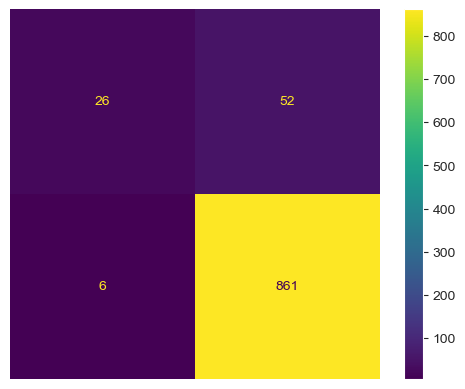

In [91]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.axis('off')
plt.show()

K-Fold cross-validation

In [92]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print('Accuracy:', accuracies.mean())
print('Standard Variance:', accuracies.std())

Accuracy: 0.930580008227067
Standard Variance: 0.008869820912239122


Applying grid search to get the optimal parameters on random forest

In [93]:
params = {
    'bootstrap': [True],
    'max_depth': [80,100],
    'min_samples_split': [8,12],
    'n_estimators': [100,300]
}

In [95]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator=model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl,y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [98]:
# Getting the best parameters from the grid search

print('Best Parameter Combination: {}'.format(grid_search.best_params_))

Best Parameter Combination: {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}


In [99]:
print('Cross validation mean accuracy on train set: {}'.format(grid_search.cv_results_['mean_train_score'].mean()*100))
print('Cross validation mean accuracy on test set: {}'.format(grid_search.cv_results_['mean_test_score'].mean() * 100))
print('Accuracy score for test set:',accuracy_score(y_test,y_pred))

Cross validation mean accuracy on train set: 96.81828493647913
Cross validation mean accuracy on test set: 92.18466424682396
Accuracy score for test set: 0.9386243386243386


In [119]:
# Saving the Random Forest classifier
pickle.dump(model_rf,open('models/model_rf.pkl','wb'))

## XGBoost

In [101]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [102]:
# Accuracy of the model on training and testing data
print ('Training accuracy:',model_xgb.score(X_train_scl,y_train))
print('Testing accuracy:',model_xgb.score(X_test_scl,y_test))

Training accuracy: 0.971415607985481
Testing accuracy: 0.9417989417989417


In [103]:
# Predicting on the test set
y_predxgb = model_xgb.predict(X_test_scl)

In [104]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_predxgb)

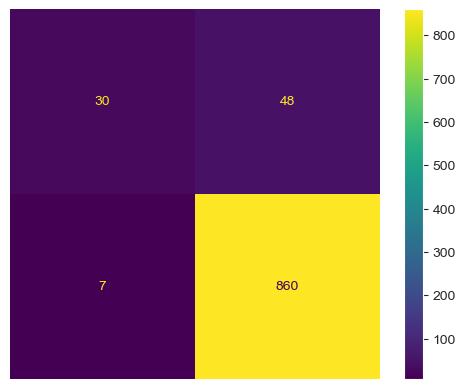

In [105]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.axis('off')
plt.show()

In [120]:
# Saving the XGBoost classifier
pickle.dump(model_xgb,open('models/model_xgb.pkl','wb'))

## Decision Tree

In [108]:
# Accuracy of the model on training and testing data
print ('Training accuracy:',model_dt.score(X_train_scl,y_train))
print('Testing accuracy:',model_dt.score(X_test_scl,y_test))

Training accuracy: 0.9945553539019963
Testing accuracy: 0.9238095238095239


In [107]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl,y_train)

DecisionTreeClassifier()

In [109]:
# Predicting on the test set
y_preddt = model_dt.predict(X_test_scl)

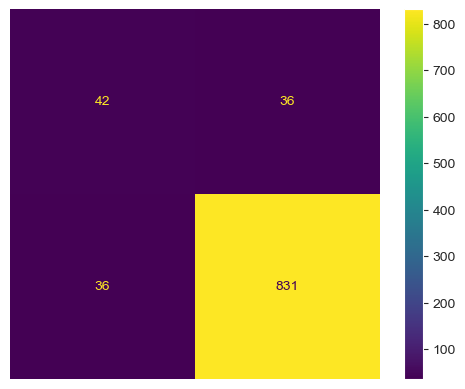

In [113]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_preddt)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.axis('off')
plt.show()

In [121]:
# Saving the Decision Tree classifier
pickle.dump(model_dt,open('models/model_dt.pkl','wb'))